In [1]:
# Purpose: Quickly analysing ENSOWind EXP to see if all okay
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                                                                                       
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.path as mpath
import time
import matplotlib.animation as animation # library that makes the movie
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m

#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Getting the shelf mask

In [2]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_ucells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000

In [3]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
# ---------------------------------------------------------------------------------- #
sel_lat   = [   0,  500]  # 81.1°S - 59.5°S                                          #
sel_lon = [1299, 2200]  # [1299, 2200] = 150°W - 60°W                                #
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

    sea_level_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).sea_level[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    sea_level        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).sea_level[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    if e == 1: 
        # sea_level_EN_anom              = ((sea_level - sea_level_clim)).load()
        sea_level_EN_anom              = ((sea_level - sea_level_clim)*above1000_tcells).load() # with masking
    if e == 2: 
        # sea_level_LN_anom              = ((sea_level - sea_level_clim)).load()
        sea_level_LN_anom              = ((sea_level - sea_level_clim)*above1000_tcells).load() # with masking
print('----------------------------------')
# Wall time: 6.93 s

01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 7.96 s, sys: 1.73 s, total: 9.69 s
Wall time: 14.7 s


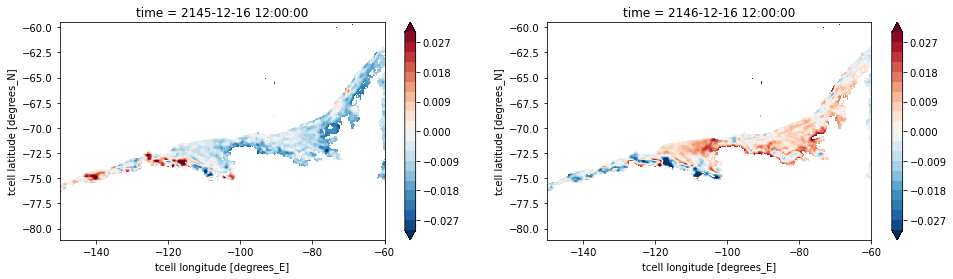

In [4]:
ticks = np.linspace(-.03,.03,21)
plt.figure(figsize=(16,4))
time_step = [11, 23]
plt.subplot(1,2,1); sea_level_EN_anom[time_step[0],:,:].plot(cmap='RdBu_r', levels=ticks)
plt.subplot(1,2,2); sea_level_LN_anom[time_step[1],:,:].plot(cmap='RdBu_r', levels=ticks)

Text(0.5, 0, 'Month of simulation')

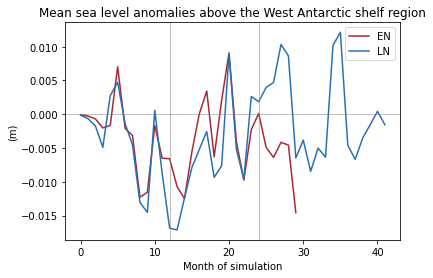

In [5]:
plt.plot(sea_level_EN_anom.mean(['yt_ocean', 'xt_ocean']), c = rotblau[3], label='EN')
plt.plot(sea_level_LN_anom.mean(['yt_ocean', 'xt_ocean']), c = rotblau[17], label='LN')
plt.axvline(12, c='grey', lw=.5); plt.axvline(24, c='grey', lw=.5); plt.axhline(0, c='grey', lw=.5); plt.legend()
plt.title('Mean sea level anomalies above the West Antarctic shelf region')
plt.ylabel('(m)'); plt.xlabel('Month of simulation')

### Plotting routine

CPU times: user 719 ms, sys: 130 ms, total: 849 ms
Wall time: 763 ms


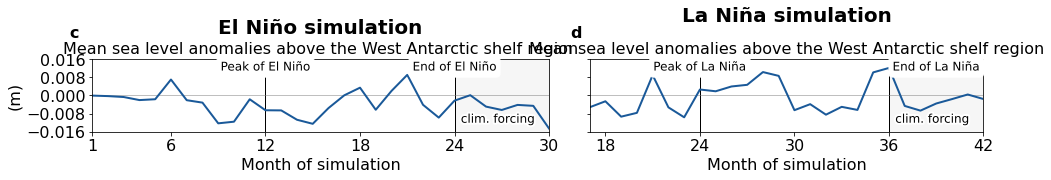

In [6]:
%%time
filename= 'Comparison_simulated_N34_and_JRA55-do'
stand = 0
time_EN = np.linspace(1,len(sea_level_EN_anom),len(sea_level_EN_anom)) # time axis of ENFull
time_LN = np.linspace(1,len(sea_level_LN_anom),len(sea_level_LN_anom)) # time axis of LNFull

ybeschriftung = '(m)'; xbeschriftung = 'Month of simulation'
ylimite = [-.016,.016]
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(14,11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,2, width_ratios=[29,25], height_ratios=[1,.5,.5,2]) 
event = ['El Niño', 'La Niña']
panel_titel = 'Mean sea level anomalies above the West Antarctic shelf region'
for f in [2,3]:
    # simulated temperature or heat content anomalies 
    # ------------------------------------------------------------------- # 
    if f == 2:
        ax1 = plt.subplot(gs[1,0]); plt.axvline(12, c = 'k', linewidth=1); plt.axvline(24, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = panel_titel
        
        plt.plot(time_EN, sea_level_EN_anom.mean(['yt_ocean', 'xt_ocean']), linewidth=2, color=rotblau[18]) # either heat content or temperature anomalies here
        
        plt.text(15.5,0.03,'El Niño simulation', fontsize=20, ha='center', va='center', fontweight='bold') # x0, y0
    if f == 3:
        ax1 = plt.subplot(gs[1,1]); plt.axvline(24, c = 'k', linewidth=1); plt.axvline(36, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = panel_titel

        plt.plot(time_LN, sea_level_LN_anom.mean(['yt_ocean', 'xt_ocean']), linewidth=2, color=rotblau[18]) 
        
        plt.text(29.5,0.035,'La Niña simulation', fontsize=20, ha='center', va='center', fontweight='bold') # x0, y0

    # specifics for only certain subplots
    # if f <= 5:  ax1.set_xticklabels([]); ax1.set(xlabel=None)
    if f in [2]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 
    if f in [1,3,5,7]: # specifics for La Niña panels on the right
        plt.xlim([17, 42]); ax1.set_xticks([18, 24, 30, 36, 42]); ax1.set_yticklabels([]); # ax1.set_xticks([18, 24, 30, 36]); 

    if f in [2]: plt.ylabel(ybeschriftung, fontsize=16) # y-axis label 
    plt.xlabel(xbeschriftung, fontsize=16) # y-axis label 
    # set axis limits
    if f in [2,3]: plt.ylim([ylimite[0], ylimite[1]]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
    if f in [4,5]: plt.ylim([-.6,1]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
   
    if f in [0]: plt.ylabel('(°C)', fontsize=16) # titles
    # if f <= 3:  ax1.set_xticklabels([]); ax1.set_xlabel(None)
    if f in [0,2,4, 6]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 

    if f in [7]: # specifics for La Niña panels on the right
        plt.xlim([17, 42]); ax1.set_xticks([18, 24, 30, 36, 42]); ax1.set_yticklabels([]); # ax1.set_xticks([18, 24, 30, 36]); 

    if f in [2,4,6]: ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing
    if f in [3,5,7]: ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

    # annotations
    if f in [2]: 
        ax1.text(12, .011, 'Peak of El Niño', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24, .011, 'End of El Niño', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24.4, -.012, 'clim. forcing', fontsize=12, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [3]: 
        ax1.text(24, .011, 'Peak of La Niña', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(39, .011, 'End of La Niña', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36.4, -.012, 'clim. forcing', fontsize=12, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        # ax1.annotate('', xy=(27, -2.6), xytext=(24.1, -2.6),xycoords='data', size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy"))
    # specifics for all subplots
    plt.title(title_str, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    ax1.text(-.05, 1.3, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
# --- saving as 300 dpi .PNG image in specified folder --------------- #
plt.savefig(save + 'sea_level_anomalies_ENSO', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,    #
            format=None, transparent=False, bbox_inches='tight',       #
            pad_inches=0.1, metadata=None)                             #
# --- end of script -------------------------------------------------- # 
# Wall time: 2.14 s

### Also creating maps of sea level anomalies during the peak of the event (months 12 and 24 respectively)

### First, load in the unmasked coordinates

In [7]:
%%time
var = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'] # get the unmasked coordinates for plotting later on
for f in range(4):
    ds = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc')[var[f]] # get the dataset structure
    ds.values = xr.open_mfdataset('/g/data/ik11/grids/ocean_grid_01.nc')[var[f]].values # feed in the unmasked data into the dataset structure
    if f == 0: geolon_t = ds
    if f == 1: geolat_t = ds
    if f == 2: geolon_c = ds
    if f == 3: geolat_c = ds # I need the xarray.DataArray 'geolon_t' (yt_ocean: 2700xt_ocean: 3600) structure for later on calculating the make_boundary_path() function
# Wall time: 2.16 s

CPU times: user 1.09 s, sys: 604 ms, total: 1.69 s
Wall time: 2.71 s


Text(0.5, 1.0, 'Peak LN SLP anoms (Pa)')

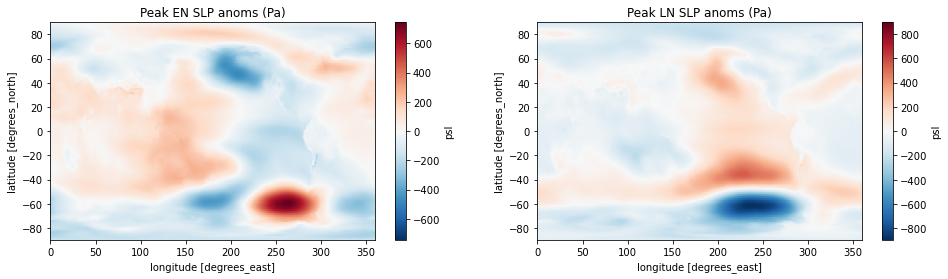

In [8]:
# first, the pressure fields for the contours
for f in range(2):
    if f == 0: suffix = 'EN'
    if f == 1: suffix = 'LN'
    slp         = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/' + 'sp_mean_anoms_'+suffix+'.nc').psl
    ts = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/time_series/' + 'ts_mean_anoms_'+suffix+'.nc').psl

    if f == 0: slp_at_peak_EN = slp * ts.max().values # get the maximum amplitude during the El Ni\~no simulation
    if f == 1: slp_at_peak_LN = slp * ts.min().values # get the minimum amplitude during the La Ni\~na simulation

plt.figure(figsize=(16,4))
plt.subplot(1,2,1); (slp_at_peak_EN   ).plot(); plt.title('Peak EN SLP anoms (Pa)')
plt.subplot(1,2,2); (slp_at_peak_LN*-1).plot(); plt.title('Peak LN SLP anoms (Pa)') # I have to multiply LN anoms with -1 because negative SLP anoms * negative time series == positive

### Define functions for plotting

In [9]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 30), # longitude grid lines
                  ylocs= np.linspace(0, -90, num=10)) # latitude grid lines
    ax.coastlines(); # add coast lines
    # theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
    # xlab =    [ 3.2,    2.4,    1.1,    .12,     -.4,     .3,    .85] # x-position of labels
    xlab =    [    1,    -.03,   -.03,    .12,    .23,     .3,      .66]#,     .41] # x-position of labels
    ylab =    [  .72,      .7,    .52,    .21,   -.04,    1.02,    1.02]#,     .05] # y-position of labels
    txt_lab = ['60°W', '150°W', '60°S', '70°S', '78°S', '120°W', '90°W']#, '150°W'] # label text
    # loop through the 7 label and surround with white space for higher visibility
    if f == 0:
        for l in range(len(xlab)):
            ax.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])      
def fancy_plot2(ax, titel):
    plt.title(titel, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    
    # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['440', '330', '220', '110', '0', '0', '55', '110']
    # ax1.set_xticklabels(labels)   
   

CPU times: user 14 µs, sys: 9 µs, total: 23 µs
Wall time: 30.5 µs


### Here the actual plotting routine

CPU times: user 32.5 s, sys: 4.21 s, total: 36.7 s
Wall time: 34.4 s


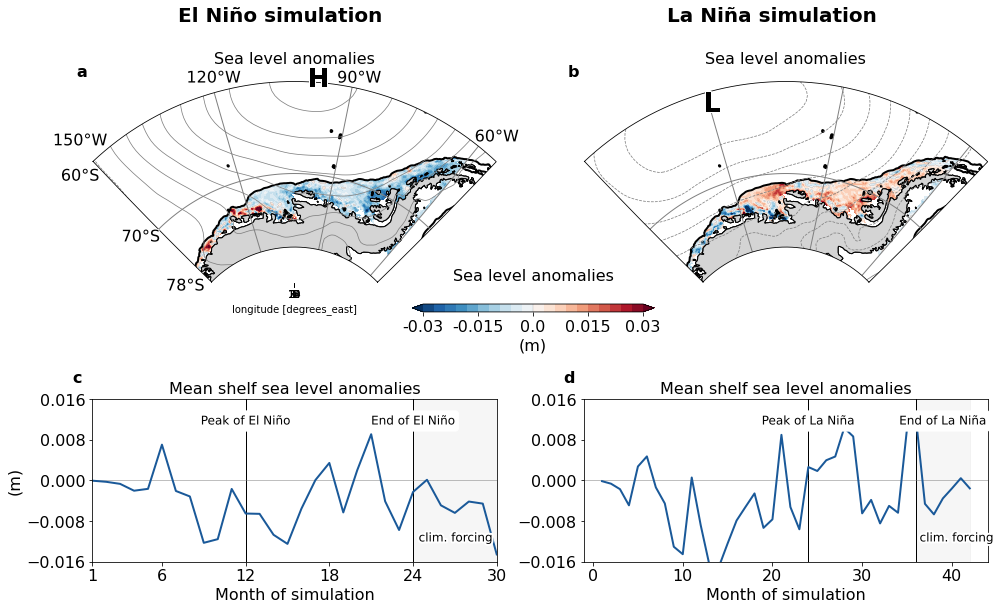

In [10]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(14, 11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, width_ratios = [1,.3,.3,1], height_ratios = [1,.5,.5]) 

midlon = -102.5
maxlon = midlon + 47.5
minlon = midlon - 47.5
minlat = -78
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-.03,.03,21)
for f in range(4): # loop through each subplot
    if f == 0:  panel = gs[0,0:2]; map = sea_level_EN_anom[time_step[0],:,:]; titel = 'Sea level anomalies\n'; pressure = slp_at_peak_EN
    if f == 1:  panel = gs[0,2:4]; map = sea_level_LN_anom[time_step[1],:,:]; titel = 'Sea level anomalies\n'; pressure = slp_at_peak_LN*-1
    if f == 2:  panel = gs[1,0:2]; data = sea_level_EN_anom.mean(['yt_ocean', 'xt_ocean']); titel = 'Mean shelf sea level anomalies'
    if f == 3:  panel = gs[1,2:4]; data = sea_level_LN_anom.mean(['yt_ocean', 'xt_ocean']); titel = 'Mean shelf sea level anomalies'

    
    # isotherm positions during the event
    # panels with spatial maps -------------------------------------------------------------------------------------------------------------------- #
    if f in [0,1]:
        ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
        ax1.coastlines(resolution='50m')

        lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
        lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

        ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

        boundary_path = make_boundary_path(lons, lats)
        ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
        p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
        # 1000 dbar isobath
        p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)          
        p2727 = (pressure/100).plot.contour(levels = np.linspace(-10,10,21), linewidths=.75, colors = 'grey', transform=ccrs.PlateCarree()) # sea level pressure contours
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        
        if f == 0: plt.text(-105,-53,'El Niño simulation', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0
        if f == 1: plt.text(-105,-53,'La Niña simulation', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0


        # plot markers of maximum anomaly amplitude
        # max lon EN,   max lat EN, max lon LN,   max lat LN
        peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
        if f == 0: 
            # peak_anom_coords = slp_anom.where(slp_anom == slp_anom.max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude

            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
            txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], 'H', c='k', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])         
        if f == 1:
            txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], 'L', c='k', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])       

        plt.title(titel, fontsize=16)
        ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # add colour bar .675
        cax = fig.add_axes([.4125, .6, .24, .01]) # position: [x0, y0, width, height]
        from matplotlib.ticker import FuncFormatter
        fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
        cb_txt = cb.set_label(label='(m)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks()
        cb.add_lines(p11) # add contours to colour bar   
# ------------------------------------------------------------------------------------------------------------------------------------------------- #
    if f == 2:
        ax1 = plt.subplot(panel); plt.axvline(12, c = 'k', linewidth=1); plt.axvline(24, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = panel_titel
        ax1.plot(time_EN, data, linewidth=2, color=rotblau[18])
        
    if f == 3:
        ax1 = plt.subplot(panel); plt.axvline(24, c = 'k', linewidth=1); plt.axvline(36, c = 'k', linewidth=1)
        plt.axhline(0, c = 'grey', linewidth=.5); title_str = panel_titel
        ax1.plot(time_LN, data, linewidth=2, color=rotblau[18]) 

    # specifics for only certain subplots
    # if f <= 5:  ax1.set_xticklabels([]); ax1.set(xlabel=None)

    if f in [2]: plt.ylabel(ybeschriftung, fontsize=16) # y-axis label 
    if f in [2,3]: plt.xlabel(xbeschriftung, fontsize=16) # y-axis label 
    # set axis limits
    if f in [2,3]: plt.ylim([ylimite[0], ylimite[1]]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
    if f in [4,5]: plt.ylim([-.6,1]); ax1.yaxis.set_major_locator(plt.MaxNLocator(5)) # five y ticks
   
    if f in [0]: plt.ylabel('(°C)', fontsize=16) # titles
    # if f <= 3:  ax1.set_xticklabels([]); ax1.set_xlabel(None)
    if f in [0,2,4, 6]: # specifics for El Niño panels on the left
        plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # adjust limit, custom x-ticks 

    if f in [2]: ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing
    if f in [3]: ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

    # annotations
    if f in [2]: 
        ax1.text(12, .011, 'Peak of El Niño', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24, .011, 'End of El Niño', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24.4, -.012, 'clim. forcing', fontsize=12, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    if f in [3]: 
        ax1.text(24, .011, 'Peak of La Niña', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(39, .011, 'End of La Niña', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36.4, -.012, 'clim. forcing', fontsize=12, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        # ax1.annotate('', xy=(27, -2.6), xytext=(24.1, -2.6),xycoords='data', size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy"))
    # specifics for all subplots
    plt.title(titel, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    if f in [2,3]: ax1.text(-.05, 1.1, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
        
# --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
plt.savefig(save + 'sea_level_maps_peak_EN_LN_simulation', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                           #
            format=None, transparent=False, bbox_inches='tight',                                              #
            pad_inches=0.1, metadata=None)                                                                    #
# --- end of script ----------------------------------------------------------------------------------------- # 
# Wall time: 38.7 s

### Saving the data as netcdf files

In [11]:
%%time
ssh_EN = sea_level_EN_anom[time_step[0],:,:].to_dataset(name='sea_level_EN_anom')
ssh_EN.attrs = {
    'Dataset': 'JRA55-do',
    'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
    'Units': '[m]', 
    'Author': 'Maurice F. Huguenin', 
    'Created': '2023-11-28', 
    'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
    'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
ssh_EN.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data_FigS16a_Sea_level_anoms_EN.nc')

ssh_LN = sea_level_LN_anom[time_step[1],:,:].to_dataset(name='sea_level_LN_anom')
ssh_EN.attrs = {
    'Dataset': 'JRA55-do',
    'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
    'Units': '[m]', 
    'Author': 'Maurice F. Huguenin', 
    'Created': '2023-11-28', 
    'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
    'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
ssh_LN.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS16b_Sea_level_anoms_LN.nc')
slp_EN = slp_at_peak_EN.to_dataset(name='slp_at_peak_EN')
slp_EN.attrs = {
    'Dataset': 'JRA55-do',
    'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
    'Units': '[hPa]', 
    'Author': 'Maurice F. Huguenin', 
    'Created': '2023-11-28', 
    'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
    'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
slp_EN.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS16a_Sea_level_pressure_anoms_EN.nc')

slp_LN = (slp_at_peak_LN*-1).to_dataset(name='slp_at_peak_LN')
slp_LN.attrs = {
    'Dataset': 'JRA55-do',
    'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
    'Units': '[hPa]', 
    'Author': 'Maurice F. Huguenin', 
    'Created': '2023-11-28', 
    'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
    'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
slp_LN.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS16b_Sea_level_pressure_anoms_LN.nc')

CPU times: user 198 ms, sys: 29.8 ms, total: 228 ms
Wall time: 300 ms


### Next addition for the schematic: showing zonal current velocities over the full West Antarctic region

In [12]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
# ---------------------------------------------------------------------------------- #
sel_lat   = [   0,  500]  # 81.1°S - 59.5°S                                          #
sel_lon   = [1299, 2200]  # [1299, 2200] = 150°W - 60°W                              #
depth     = [  23,   47]  # 98 m - 1017 m depth                                      #
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

    u_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    u        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    if e == 1: 
        u_EN_anom              = ((u - u_clim)*above1000_ucells).load()
    if e == 2: 
        u_LN_anom              = ((u - u_clim)*above1000_ucells).load()
print('----------------------------------')
# Wall time: 6.93 s

01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 12.3 s, sys: 6.09 s, total: 18.4 s
Wall time: 29.3 s


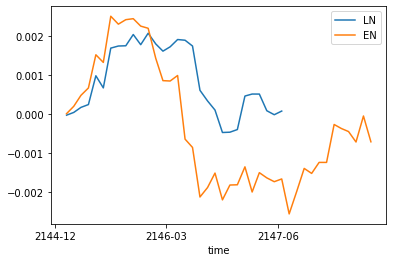

In [13]:
u_EN_anom.mean(['st_ocean', 'yu_ocean', 'xu_ocean']).plot(label='LN')
u_LN_anom.mean(['st_ocean', 'yu_ocean', 'xu_ocean']).plot(label='EN'); plt.legend()

CPU times: user 4.06 s, sys: 406 ms, total: 4.46 s
Wall time: 4.04 s


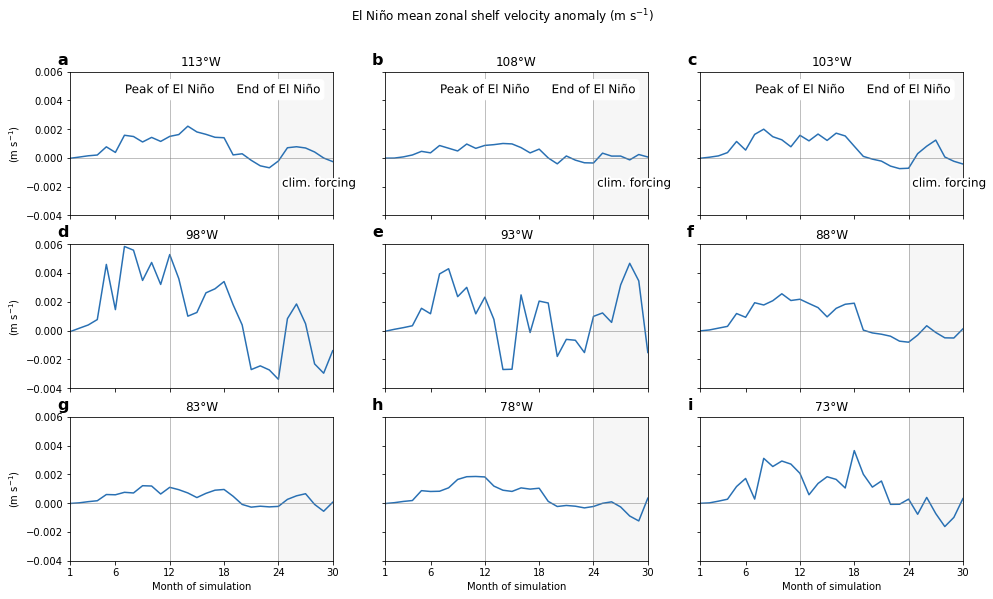

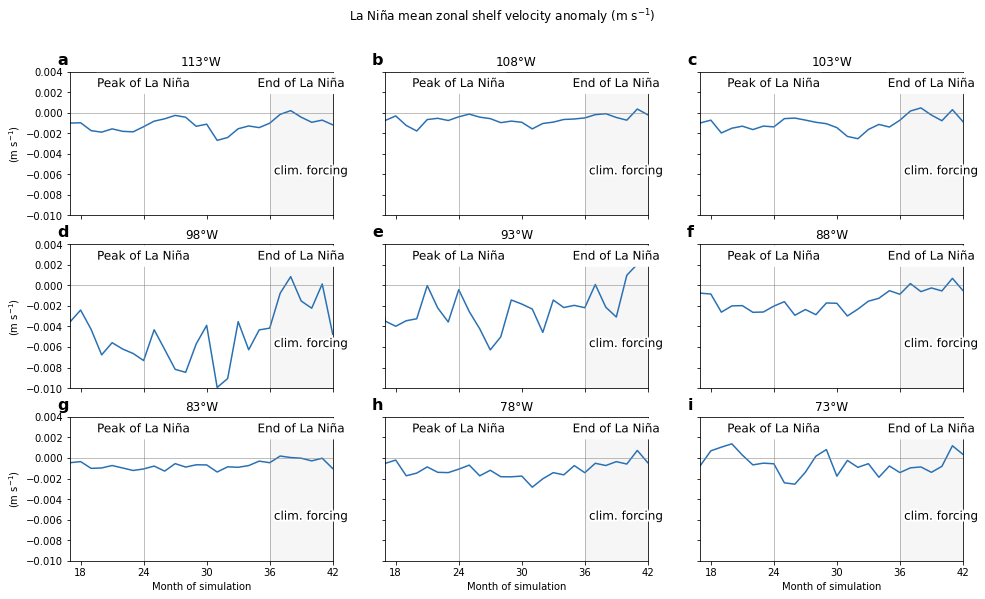

In [14]:
%%time
longitudes = [-113, -108, -103, -98, -93, -88, -83, -78, -73]
name = ['', 'El Niño', 'La Niña']

for e in [1,2]:
    plt.figure(figsize=(16,9))
    if e == 1: ts = time_EN; data = u_EN_anom
    if e == 2: ts = time_LN; data = u_LN_anom
    
    for f in range(9):
        ax1 = plt.subplot(3,3,f+1)
        ts_zonal = data[:,:,:,:].sel(xu_ocean=longitudes[f], method='nearest').mean(['st_ocean', 'yu_ocean'])
        plt.plot(ts, ts_zonal, c=rotblau[17])
        plt.title(str(abs(longitudes[f]))+'°W')
        plt.axhline(0, c='grey', lw=.5)
        if e in [1]: 
            plt.axvline(12, c='grey', lw=.5); plt.axvline(24, c='grey', lw=.5)
            ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2)
            plt.xlim([ 1, 30]); ax1.set_xticks([1, 6, 12, 18, 24, 30]) # shade period where I applied climatological, RYF, forcing
            plt.ylim([-.004,.006])
        if e in [2]: 
            plt.axvline(24, c='grey', lw=.5); plt.axvline(36, c='grey', lw=.5)
            ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2)
            plt.xlim([17, 42]); ax1.set_xticks([18, 24, 30, 36, 42])
            plt.ylim([-.01,.004])

        if f in [1,2,4,5,7,8]: ax1.set_yticklabels([])
        if f <=5: ax1.set_xticklabels([])
        if f >5: plt.xlabel('Month of simulation')
        if f in [0,3,6]: plt.ylabel('(m s$^{-1}$)')

        # annotations
        if e in [1] and f <= 2: 
            ax1.text(12, .0045, 'Peak of El Niño', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                    ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
            ax1.text(24, .0045, 'End of El Niño', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                    ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
            ax1.text(24.4, -.002, 'clim. forcing', fontsize=12, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        if e in [2]: 
            ax1.text(24, .0025, 'Peak of La Niña', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                    ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
            ax1.text(39, .0025, 'End of La Niña', fontsize=12, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                    ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
            ax1.text(36.4, -.006, 'clim. forcing', fontsize=12, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        
        ax1.text(-.05, 1.05, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.suptitle(name[e] + ' mean zonal shelf velocity anomaly (m s$^{-1}$)')
    # --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
    plt.savefig(save + 'zonal_shelf_velocity_anomalies_'+name[e], dpi=300, facecolor='w', #
                edgecolor='w', orientation='landscape', papertype=None,                                           #
                format=None, transparent=False, bbox_inches='tight',                                              #
                pad_inches=0.1, metadata=None)                                                                    #
    # --- end of script ----------------------------------------------------------------------------------------- # 